In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [17]:
data_dir = "/kaggle/input/abstract-art-gallery/Abstract_gallery/Abstract_gallery"


In [18]:
import os
from PIL import Image
from torch.utils.data import Dataset

class ArtDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = [
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img


In [19]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [20]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ArtDataset(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print("Number of images:", len(dataset))


Number of images: 2782


In [21]:
images = next(iter(dataloader))
print(images.shape)


torch.Size([64, 3, 64, 64])


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [28]:
criterion = nn.BCELoss()


In [29]:

class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 256, 4, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)


In [30]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.net(x)
        return x.view(x.size(0), -1).mean(1, keepdim=True)


In [31]:
z_dim = 100

G = Generator(z_dim).to(device)
D = Discriminator().to(device)


In [32]:
opt_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))


In [33]:
epochs = 50
loss_G, loss_D = [], []

torch.manual_seed(42)

for epoch in range(epochs):
    for real in dataloader:
        real = real.to(device)
        batch_size = real.size(0)

        # Label smoothing
        real_labels = torch.full((batch_size, 1), 0.9).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ======================
        # Train Discriminator
        # ======================
        z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = G(z)

        D_real = D(real)
        D_fake = D(fake.detach())

        loss_d = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

        opt_D.zero_grad()
        loss_d.backward()
        opt_D.step()

        # ======================
        # Train Generator (2 steps)
        # ======================
        for _ in range(2):
            z = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake = G(z)                     # 🔑 nouveau graphe
            D_fake = D(fake)

            loss_g = criterion(D_fake, real_labels)

            opt_G.zero_grad()
            loss_g.backward()
            opt_G.step()

    loss_D.append(loss_d.item())
    loss_G.append(loss_g.item())

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {loss_d.item():.4f} | G Loss: {loss_g.item():.4f}")
torch.save(G.state_dict(), "/kaggle/working/generator.pth")


Epoch [1/50] | D Loss: 0.8535 | G Loss: 2.0486
Epoch [2/50] | D Loss: 0.5029 | G Loss: 2.7470
Epoch [3/50] | D Loss: 0.4155 | G Loss: 3.0162
Epoch [4/50] | D Loss: 0.3742 | G Loss: 3.4182
Epoch [5/50] | D Loss: 0.3731 | G Loss: 3.6817
Epoch [6/50] | D Loss: 0.3769 | G Loss: 3.5227
Epoch [7/50] | D Loss: 0.3498 | G Loss: 4.0250
Epoch [8/50] | D Loss: 0.3471 | G Loss: 3.9246
Epoch [9/50] | D Loss: 0.3394 | G Loss: 4.2836
Epoch [10/50] | D Loss: 0.3348 | G Loss: 4.5757
Epoch [11/50] | D Loss: 0.3417 | G Loss: 4.2981
Epoch [12/50] | D Loss: 0.3365 | G Loss: 4.7020
Epoch [13/50] | D Loss: 0.3363 | G Loss: 4.7133
Epoch [14/50] | D Loss: 0.3323 | G Loss: 5.0119
Epoch [15/50] | D Loss: 0.3323 | G Loss: 5.0566
Epoch [16/50] | D Loss: 0.3343 | G Loss: 4.9606
Epoch [17/50] | D Loss: 0.3299 | G Loss: 5.1752
Epoch [18/50] | D Loss: 0.3323 | G Loss: 5.1587
Epoch [19/50] | D Loss: 0.3323 | G Loss: 5.4259
Epoch [20/50] | D Loss: 0.3298 | G Loss: 5.3650
Epoch [21/50] | D Loss: 0.3320 | G Loss: 5.5980
E

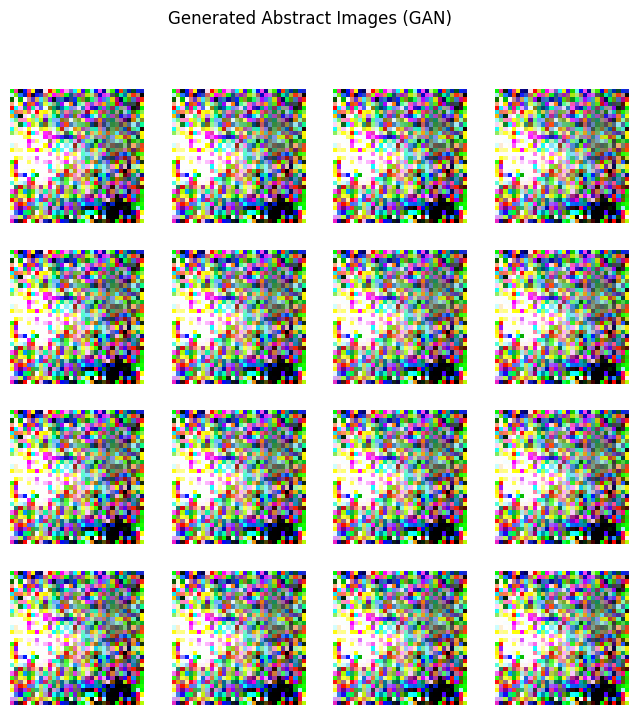

In [34]:
G.eval()
z = torch.randn(16, z_dim, 1, 1).to(device)
fake_images = G(z).detach().cpu()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    img = (fake_images[i] + 1) / 2
    ax.imshow(img.permute(1, 2, 0))
    ax.axis("off")
plt.suptitle("Generated Abstract Images (GAN)")
plt.show()
